In [ ]:
install.packages(c("RcppArmadillo", "ggplot2"), lib = "~/temp_R_libs")
devtools::install_github("stephenslab/susieR", lib = "~/temp_R_libs")

In [ ]:
.libPaths(c("~/temp_R_libs", .libPaths()))
library(susieR, lib.loc = "~/temp_R_libs")

In [1]:
library(susieR)
library(ggplot2)
theme_set(theme_minimal(base_family = "Roboto"))

## Run analysis first

In [3]:
##### library(RcppArmadillo, lib.loc = "~/temp_R_libs")
# library(ggplot2)
library(gridExtra)
library(grid)
library(ggpubr)
library(cowplot)
library(dplyr)
library(gridExtra)

# Load data
your_path <- "./"
small_data <- readRDS(paste0(your_path, "MiGA_eQTL.chr2_ENSG00000151694.univariate_data.rds"))
y <- small_data$ENSG00000151694$residual_Y[[3]]
X <- small_data$ENSG00000151694$residual_X[[3]]

In [4]:
head(colnames(X))

[1] "chr2:6843217:G:A" "chr2:6843960:A:G" "chr2:6845038:G:C" "chr2:6848538:C:T"
[5] "chr2:6849889:C:T" "chr2:6854646:C:T"

In [5]:
# Run SuSiE analyses
res_susie <- susie(X = X, y = y, L = 20)
res_susie_small <- susie(X = X, y = y, L = 10, small = TRUE)

HINT: The dataset contains fewer than 80 individuals. Credible sets may be poorly calibrated when using the default Gaussian prior with limited data. Consider setting small = TRUE to use the Servin and Stephens prior, which provides better calibration in small sample sizes.




[1] "SS SER R²: 0.847"
[1] "Default SER R²: 0.999"


In [6]:
res_susie$sets$cs

$L1
[1] 4919 4920

$L2
[1] 455 456 457 462

$L3
[1] 6902

$L4
[1] 3258

$L5
 [1] 1658 1660 1661 1665 1667 1668 1670 1672 1673 1674 1675 1676 1678 1679 1680
[16] 1681 1682 1683 1691 1695 1697

$L6
[1] 4703

$L7
[1] 5174 5181 5184

$L8
[1] 3288

$L9
 [1] 3978 3979 3980 3981 3984 3985 3987 3988 3989 3990 3991 3992 3993 3994 3996
[16] 3997 3998 3999 4000 4001

In [7]:
res_susie_small$sets$cs

$L1
[1] 4919 4920

$L2
[1] 455 456 457 462

Get the variant names per CS:

In [ ]:
get_top_variants_per_cs <- function(res_susie, variant_names) {
  # Check inputs
  if (!("sets" %in% names(res_susie)) || !("cs" %in% names(res_susie$sets))) {
    stop("res_susie must have $sets$cs structure")
  }
  if (!("pip" %in% names(res_susie))) {
    stop("res_susie must have $pip vector")
  }
  if (length(res_susie$pip) != length(variant_names)) {
    stop("Length of pip vector must match length of variant_names")
  }
  
  # Get the credible sets
  cs_list <- res_susie$sets$cs
  pip_vector <- res_susie$pip
  
  # Initialize result list
  result <- list()
  
  # Process each credible set
  for (cs_name in names(cs_list)) {
    # Get indices for this credible set
    indices <- cs_list[[cs_name]]
    
    # Get PIP values for these indices
    pip_values <- pip_vector[indices]
    
    # Find which position has the maximum PIP
    max_pos <- which.max(pip_values)
    
    # Get the actual index with max PIP
    best_idx <- indices[max_pos]
    
    # Store results
    result[[cs_name]] <- list(
      index = best_idx,
      pip = pip_vector[best_idx],
      variant_name = variant_names[best_idx]
    )
  }
  
  return(result)
}


get_top_variants_df <- function(res_susie, variant_names) {
  result_list <- get_top_variants_per_cs(res_susie, variant_names)
  
  # Convert to data frame
  df <- do.call(rbind, lapply(names(result_list), function(cs_name) {
    data.frame(
      cs = cs_name,
      index = result_list[[cs_name]]$index,
      pip = result_list[[cs_name]]$pip,
      variant = result_list[[cs_name]]$variant_name,
      stringsAsFactors = FALSE
    )
  }))
  
  return(df)
}

In [9]:
top_vars_original <- get_top_variants_df(res_susie, colnames(X))
top_vars_small <- get_top_variants_df(res_susie_small, colnames(X))

In [10]:
top_vars_original

,cs,index,pip,variant
,<chr>,<int>,<dbl>,<chr>
chr2:9703940:G:C,L1,4919,0.50053401,chr2:9703940:G:C
chr2:7070047:C:T,L2,455,0.25080098,chr2:7070047:C:T
chr2:10349456:C:G,L3,6902,1.00000000,chr2:10349456:C:G
chr2:8631391:C:A,L4,3258,1.00000000,chr2:8631391:C:A
chr2:7712072:C:T,L5,1658,0.04705867,chr2:7712072:C:T
chr2:9623516:A:G,L6,4703,1.00000000,chr2:9623516:A:G
chr2:9781944:C:T,L7,5174,0.33404538,chr2:9781944:C:T
chr2:8644513:C:T,L8,3288,1.00000000,chr2:8644513:C:T
chr2:9186723:T:C,L9,3978,0.05057316,chr2:9186723:T:C


In [11]:
top_vars_small

,cs,index,pip,variant
,<chr>,<int>,<dbl>,<chr>
chr2:9703940:G:C,L1,4919,0.4995428,chr2:9703940:G:C
chr2:7070047:C:T,L2,455,0.2490460,chr2:7070047:C:T


In [12]:
get_cs_genomic_ranges <- function(res_susie, variant_names) {
  # Check inputs
  if (!("sets" %in% names(res_susie)) || !("cs" %in% names(res_susie$sets))) {
    stop("res_susie must have $sets$cs structure")
  }
  if (length(variant_names) == 0) {
    stop("variant_names cannot be empty")
  }
  
  # Get the credible sets
  cs_list <- res_susie$sets$cs
  
  # Initialize result list
  result <- list()
  
  # Process each credible set
  for (cs_name in names(cs_list)) {
    # Get indices for this credible set
    indices <- cs_list[[cs_name]]
    
    # Get min and max indices
    min_idx <- min(indices)
    max_idx <- max(indices)
    
    # Get corresponding variant names
    min_variant <- variant_names[min_idx]
    max_variant <- variant_names[max_idx]
    
    # Parse variant names to extract chr and position
    # Format is chr2:9703940:G:C
    min_parts <- strsplit(min_variant, ":")[[1]]
    max_parts <- strsplit(max_variant, ":")[[1]]
    
    # Extract chromosome (remove "chr" prefix if present)
    min_chr <- gsub("^chr", "", min_parts[1])
    max_chr <- gsub("^chr", "", max_parts[1])
    
    # Extract positions
    min_pos <- as.numeric(min_parts[2])
    max_pos <- as.numeric(max_parts[2])
    
    # Check if chromosomes match (they should for a credible set)
    if (min_chr != max_chr) {
      warning(paste("Different chromosomes in", cs_name, ":", min_chr, "vs", max_chr))
      variant_range <- paste0(min_chr, ":", min_pos, "-", max_chr, ":", max_pos)
    } else {
      # Create the range string
      variant_range <- paste0(min_chr, ":", min_pos, "-", max_pos)
    }
    
    # Store results
    result[[cs_name]] <- list(
      min_index = min_idx,
      max_index = max_idx,
      min_variant = min_variant,
      max_variant = max_variant,
      variant_range = variant_range,
      n_variants = length(indices)  # bonus: number of variants in the CS
    )
  }
  
  return(result)
}

# If you want a cleaner data frame output:
get_cs_genomic_ranges_df <- function(res_susie, variant_names) {
  result_list <- get_cs_genomic_ranges(res_susie, variant_names)
  
  # Convert to data frame
  df <- do.call(rbind, lapply(names(result_list), function(cs_name) {
    data.frame(
      cs = cs_name,
      min_index = result_list[[cs_name]]$min_index,
      max_index = result_list[[cs_name]]$max_index,
      min_variant = result_list[[cs_name]]$min_variant,
      max_variant = result_list[[cs_name]]$max_variant,
      variant_range = result_list[[cs_name]]$variant_range,
      n_variants = result_list[[cs_name]]$n_variants,
      stringsAsFactors = FALSE
    )
  }))
  
  return(df)
}

# Usage:
# ranges <- get_cs_genomic_ranges(res_susie, variant_names)
# ranges_df <- get_cs_genomic_ranges_df(res_susie, variant_names)

In [13]:
get_cs_genomic_ranges_df(res_susie, colnames(X))

cs,min_index,max_index,min_variant,max_variant,variant_range,n_variants
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>
L1,4919,4920,chr2:9703940:G:C,chr2:9704049:G:A,2:9703940-9704049,2
L2,455,462,chr2:7070047:C:T,chr2:7071125:A:G,2:7070047-7071125,4
L3,6902,6902,chr2:10349456:C:G,chr2:10349456:C:G,2:10349456-10349456,1
L4,3258,3258,chr2:8631391:C:A,chr2:8631391:C:A,2:8631391-8631391,1
L5,1658,1697,chr2:7712072:C:T,chr2:7733761:G:C,2:7712072-7733761,21
L6,4703,4703,chr2:9623516:A:G,chr2:9623516:A:G,2:9623516-9623516,1
L7,5174,5184,chr2:9781944:C:T,chr2:9785320:T:C,2:9781944-9785320,3
L8,3288,3288,chr2:8644513:C:T,chr2:8644513:C:T,2:8644513-8644513,1
L9,3978,4001,chr2:9186723:T:C,chr2:9190216:A:G,2:9186723-9190216,20


In [14]:
get_cs_genomic_ranges_df(res_susie_small, colnames(X))

cs,min_index,max_index,min_variant,max_variant,variant_range,n_variants
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>
L1,4919,4920,chr2:9703940:G:C,chr2:9704049:G:A,2:9703940-9704049,2
L2,455,462,chr2:7070047:C:T,chr2:7071125:A:G,2:7070047-7071125,4


We look for 2:9558882-9558888 (as per https://adsp.niagads.org/gvc-top-hits-list/ Table 1) we found GCST90027158 and GCST90301303 two studies (accessions) have significant both AD. 

Also 2:7000000-10350000 in GWAS catelog, like this: https://www.ebi.ac.uk/gwas/regions/chr2:7000000-10350000 and we found the only ones with significance are also just 2:9558882 which is not in a CS from SS model.

## Fig 1C

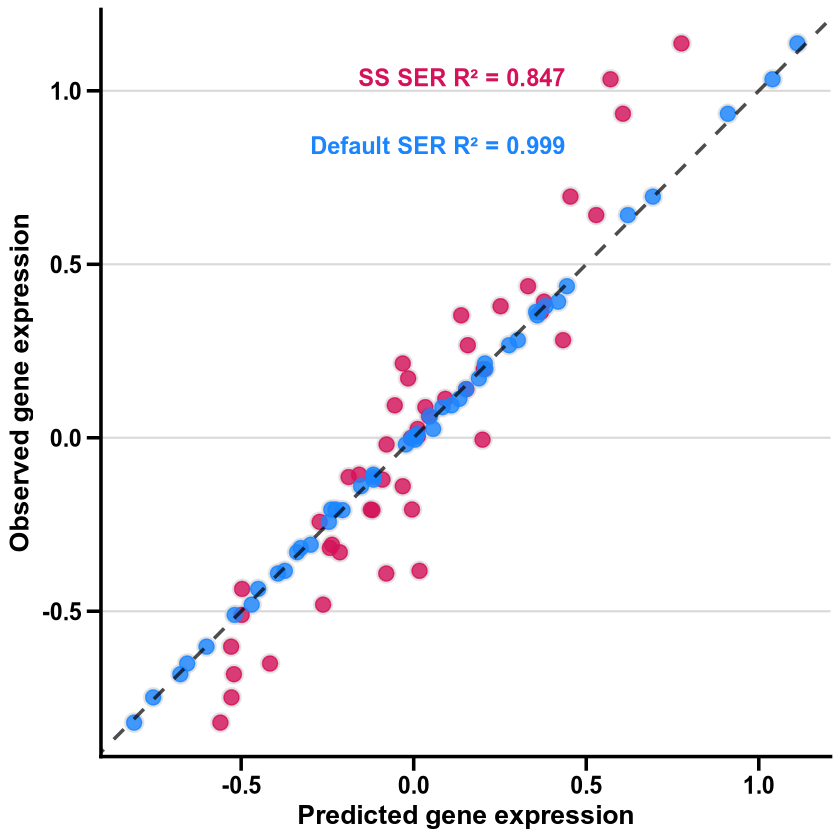

In [10]:
method1 <- "Servin & Stephens SER"
method2 <- "Default SER"
methods_colors <- setNames(c("#D41159", "#1A85FF"), c(method1, method2))

# Calculate variance explained
var_explained_small <- 1 - var(y - predict(res_susie_small))/var(y)
var_explained_default <- 1 - var(y - predict(res_susie))/var(y)

print(paste("SS SER R²:", round(var_explained_small, 3)))
print(paste("Default SER R²:", round(var_explained_default, 3)))


# Create data frame for plotting
df_plot_pred <- data.frame(
  y = rep(y, 2),
  x = c(predict(res_susie_small, X),
        predict(res_susie, X)),
  col = factor(c(
    rep(method1, length(predict(res_susie_small, X))),
    rep(method2, length(predict(res_susie, X)))
  ))
)

# Calculate correlation for each method
cor_small <- cor(y, predict(res_susie_small, X))
cor_default <- cor(y, predict(res_susie, X))

# Create the improved plot
P_pred <- ggplot(df_plot_pred, aes(y = y, x = x, col = col)) +
  # Add gray background points for all data
  geom_point(data = df_plot_pred, 
             aes(y = y, x = x), 
             color = "gray85", 
             size = 5, 
             alpha = 0.6) +
  # Add colored points on top
  geom_point(size = 3.8, alpha = 0.8) +
  # Add diagonal reference line
  geom_abline(slope = 1, intercept = 0, 
              linetype = "dashed", 
              color = "black", 
              size = 1.0, 
              alpha = 0.7) +
  # Labels with larger, bolder text
  ylab("Observed gene expression") +
  xlab("Predicted gene expression") +
  # Apply clean theme with modifications
  theme_cowplot(font_size = 14) +
  theme(
    # Remove legend as requested
    legend.position = "none",
    # Make panel background white with horizontal grid only
    panel.background = element_rect(fill = "white", color = NA),
    panel.grid.major.y = element_line(color = "gray85", size = 0.6),
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    # Make axis text larger and bolder
    axis.text = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 16, face = "bold"),
    # Minimize margins to reduce whitespace
    plot.margin = margin(t = 2, r = 2, b = 2, l = 2, unit = "mm"),
    # Make axis lines bolder
    axis.line = element_line(size = 1.0, color = "black"),
    axis.ticks = element_line(size = 1.0, color = "black"),
    axis.ticks.length = unit(0.3, "cm"),
    # Ensure clean appearance
    panel.border = element_blank()
  ) +
  # Set custom colors
  scale_color_manual(
    values = methods_colors,
    name = ""
  ) +
  # Add R² annotations using the methods_colors vector
  annotate("text", 
           x = max(df_plot_pred$x) - 0.35 * diff(range(df_plot_pred$x)),
           y = max(df_plot_pred$y) - 0.05 * diff(range(df_plot_pred$y)),
           label = paste0("SS SER R² = ", round(var_explained_small, 3)),
           color = methods_colors[method1],
           size = 5, 
           fontface = "bold",
           hjust = 1) +
  annotate("text", 
           x = max(df_plot_pred$x) - 0.35 * diff(range(df_plot_pred$x)),
           y = max(df_plot_pred$y) - 0.15 * diff(range(df_plot_pred$y)),
           label = paste0(method2, " R² = ", round(var_explained_default, 3)),
           color = methods_colors[method2],
           size = 5, 
           fontface = "bold",
           hjust = 1)

# Display the plot
P_pred

## Fig 1B

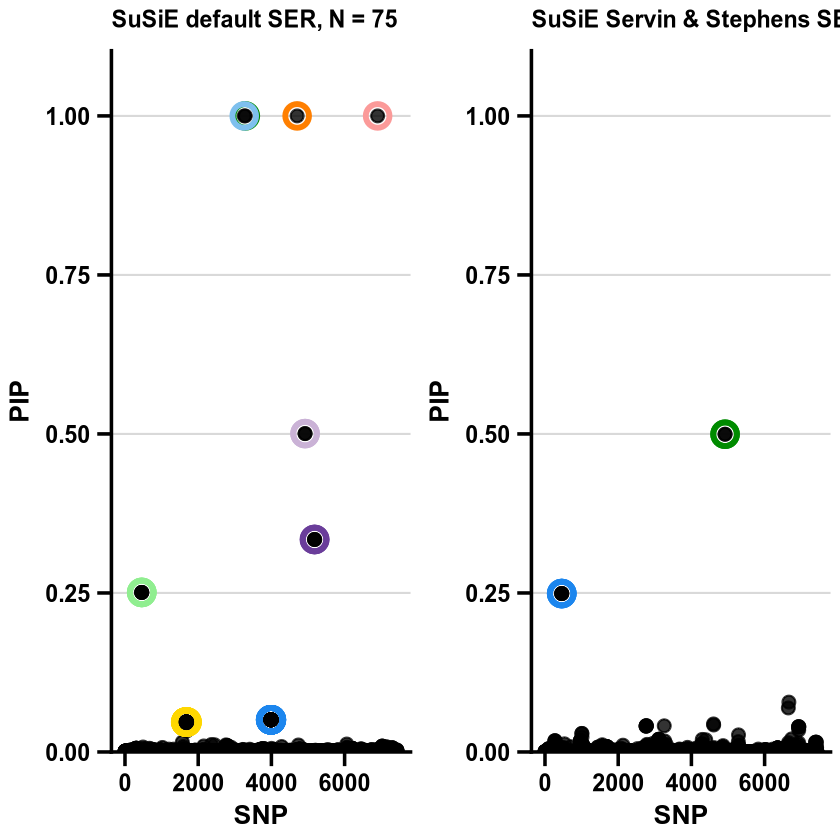

In [11]:
#### PIP Plot -----
color <- c("dodgerblue2", "green4", "#6A3D9A", "#FF7F00", "gold1", "skyblue2", 
           "#FB9A99", "palegreen2", "#CAB2D6", "#FDBF6F", "gray70", "khaki2", 
           "maroon", "orchid1", "deeppink1", "blue1", "steelblue4",
           "darkturquoise", "green1", "yellow4", "yellow3", "darkorange4", "brown")

# Function to create improved PIP plot
create_pip_plot <- function(model, title_text) {
  is_susie <- inherits(model, "susie")
  y <- "PIP"
  pos <- NULL
  b <- NULL
  max_cs <- 400
  
  # Extract PIP values
  if (y == "PIP") {
    if (is_susie) {
      p <- model$pip
    } else {
      p <- model
    }
  }
  ylab <- "PIP"
  if (is.null(b)) b <- rep(0, length(p))
  if (is.null(pos)) pos <- 1:length(p)
  df <- data.frame(pos = pos, p = p, b = b)
  
  # Base plot: ALL points in black
  gg <- ggplot(df, aes(x = pos, y = p)) +
    geom_point(color = "black", size = 3, alpha = 0.8) +  # Changed to black
    labs(x = "SNP", y = ylab) +
    scale_y_continuous(
      limits = c(0, 1.05),
      expand = expansion(mult = c(0, 0.05))
    ) +
    theme_cowplot(font_size = 20) +
    theme(
      legend.position = "none",
      panel.grid.major.y = element_line(color = "gray85", size = 0.6),
      panel.grid.major.x = element_blank(),
      panel.grid.minor = element_blank(),
      axis.text = element_text(size = 14, face = "bold"),
      axis.title = element_text(size = 16, face = "bold"),
      plot.margin = margin(t = 2, r = 2, b = 2, l = 2, unit = "mm"),
      axis.line = element_line(size = 1.0, color = "black"),
      axis.ticks = element_line(size = 1.0, color = "black"),
      axis.ticks.length = unit(0.3, "cm"),
      plot.title = element_text(size = 14, face = "bold"),
      panel.border = element_blank(),
      panel.background = element_rect(fill = "white", color = NA)
    )
  
  # Add credible set highlights - ONLY colored circles, no fill
  for (i in rev(1:nrow(model$alpha))) {
    if (!is.null(model$sets$cs_index) && !(i %in% model$sets$cs_index)) next
    
    if (susieR:::n_in_CS(model, model$sets$requested_coverage)[i] < max_cs) {
      x0 <- intersect(pos, which(susieR:::in_CS(model, model$sets$requested_coverage)[i, ] > 0))
      y1 <- p[x0]
    } else {
      next
    }
    if (is.null(x0)) next
    
    cs_color <- head(color, 1)
    
    # ONLY add colored circle outline around CS points
    # The black dot is already there from the base layer
    gg <- gg + geom_point(data = data.frame(pos = x0, p = y1),
                          aes(x = pos, y = p),
                          color = cs_color,
                          shape = 1,           # Circle shape (hollow)
                          stroke = 2.5,        # Bold stroke weight
                          size = 5)            # Slightly larger to encompass the black dot
    
    # Rotate color palette for next CS
    color <- c(color[-1], color[1])
  }
  
  gg <- gg + ggtitle(title_text)
  return(gg)
}

# Example usage
pip_plot_susie <- create_pip_plot(res_susie, "SuSiE default SER, N = 75")
pip_plot_susie_small <- create_pip_plot(res_susie_small, "SuSiE Servin & Stephens SER")

# Arrange plots
grid.arrange(pip_plot_susie, pip_plot_susie_small, ncol = 2)

## Fig 1A

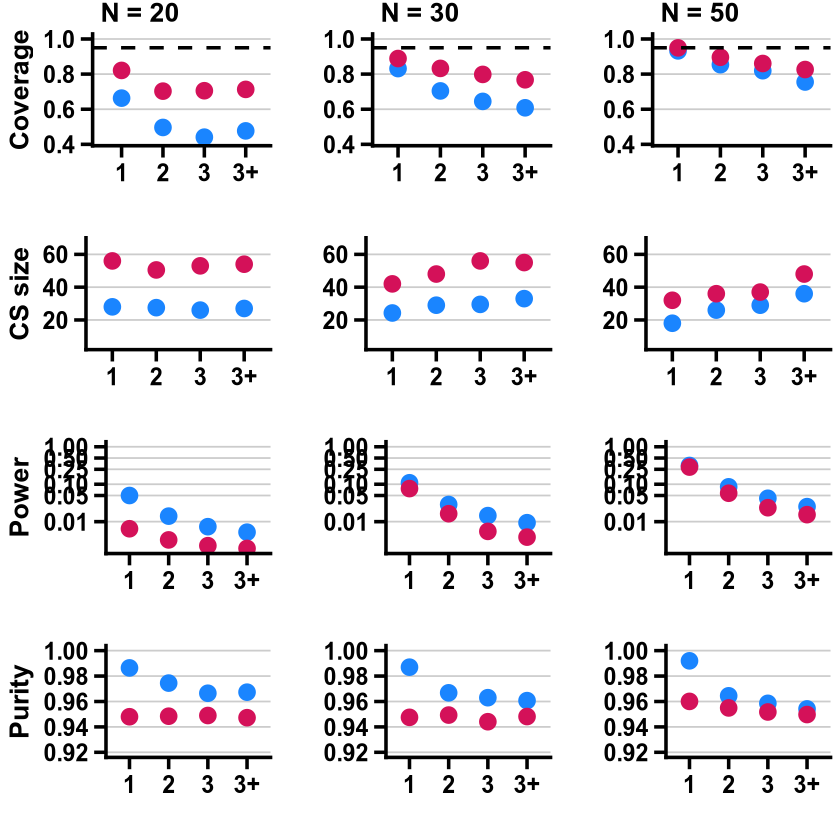

In [21]:
load(paste0(your_path, "summary_L1_3.RData"))
combined_data = combined_data[- which(combined_data$n == 10),]

library(ggplot2)
library(cowplot)
library(gridExtra)
# Define method names for display
method1_display <- "Servin & Stephens SER"
method2_display <- "Default SER"

methods_colors <- c("SER SS" = "#D41159", "SER Gaus" = "#1A85FF")

# Define common theme for all plots
perf_theme <- theme_cowplot(font_size = 16) +
  theme(
    legend.position = "none",
    panel.grid.major.y = element_line(color = "gray80"),  # keep horizontal lines
    panel.grid.major.x = element_blank(),                 # remove vertical lines
    panel.grid.minor = element_blank(),
    axis.line = element_line(size = 1, color = "black"),
    axis.ticks = element_line(size = 1, color = "black"),
    axis.ticks.length = unit(0.25, "cm"),
    plot.margin = margin(t = 2, r = 2, b = 2, l = 2, unit = "mm"),
    axis.text = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 16, face = "bold"),
    plot.title = element_text(size = 16, face = "bold")
  )

dot_size = 4

# Coverage
P11 <- ggplot(combined_data[which(combined_data$n == 20 & combined_data$h2 == 25),],
              aes(y = obs_cov, x = as.factor(L), col = BF)) +
  geom_point(size = dot_size) +
  ylab("Coverage") + xlab("") +
  geom_hline(yintercept = 0.95, linetype = "dashed", color = "black", size = 1) +
  annotate("text", x = 0.3, y = 0.95, label = "",
           hjust = -0.1, vjust = -0.5, size = 3.5, fontface = "italic") +
  ylim(c(min(combined_data$obs_cov - 0.02), 1)) +
  scale_color_manual(values = methods_colors) +
  perf_theme

P12 <- ggplot(combined_data[which(combined_data$n == 30 & combined_data$h2 == 25),],
              aes(y = obs_cov, x = as.factor(L), col = BF)) +
  geom_point(size = dot_size) +
  xlab("") + ylab("") +
  geom_hline(yintercept = 0.95, linetype = "dashed", color = "black", size = 1) +
  ylim(c(min(combined_data$obs_cov - 0.02), 1)) +
  scale_color_manual(values = methods_colors) +
  perf_theme

P13 <- ggplot(combined_data[which(combined_data$n == 50 & combined_data$h2 == 25),],
              aes(y = obs_cov, x = as.factor(L), col = BF)) +
  geom_point(size = dot_size) +
  xlab("") + ylab("") +
  geom_hline(yintercept = 0.95, linetype = "dashed", color = "black", size = 1) +
  ylim(c(min(combined_data$obs_cov - 0.02), 1)) +
  scale_color_manual(values = methods_colors) +
  perf_theme

# CS size
P21 <- ggplot(combined_data[which(combined_data$n == 20 & combined_data$h2 == 25),],
              aes(y = cs_size, x = as.factor(L), col = BF)) +
  geom_point(size = dot_size) +
  ylab("CS size") + xlab("") +
  ylim(range(combined_data$cs_size)) +
  scale_color_manual(values = methods_colors) +
  perf_theme

P22 <- ggplot(combined_data[which(combined_data$n == 30 & combined_data$h2 == 25),],
              aes(y = cs_size, x = as.factor(L), col = BF)) +
  geom_point(size = dot_size) +
  xlab("") + ylab("") +
  ylim(range(combined_data$cs_size)) +
  scale_color_manual(values = methods_colors) +
  perf_theme

P23 <- ggplot(combined_data[which(combined_data$n == 50 & combined_data$h2 == 25),],
              aes(y = cs_size, x = as.factor(L), col = BF)) +
  geom_point(size = dot_size) +
  xlab("") + ylab("") +
  ylim(range(combined_data$cs_size)) +
  scale_color_manual(values = methods_colors) +
  perf_theme

# Power - back to original theme
P31 <- ggplot(combined_data[which(combined_data$n == 20 & combined_data$h2 == 25),],
              aes(y = power, x = as.factor(L), col = BF)) +
  geom_point(size = dot_size) +
  ylab("Power") + xlab("") +
  scale_y_log10(limits = c(min(combined_data$power), 1),
                breaks = c(0.01, 0.05, 0.1, 0.25, 0.5, 1)) +
  scale_color_manual(values = methods_colors) +
  perf_theme

P32 <- ggplot(combined_data[which(combined_data$n == 30 & combined_data$h2 == 25),],
              aes(y = power, x = as.factor(L), col = BF)) +
  geom_point(size = dot_size) +
  xlab("") + ylab("") +
  scale_y_log10(limits = c(min(combined_data$power), 1),
                breaks = c(0.01, 0.05, 0.1, 0.25, 0.5, 1)) +
  scale_color_manual(values = methods_colors) +
  perf_theme

P33 <- ggplot(combined_data[which(combined_data$n == 50 & combined_data$h2 == 25),],
              aes(y = power, x = as.factor(L), col = BF)) +
  geom_point(size = dot_size) +
  xlab("") + ylab("") +
  scale_y_log10(limits = c(min(combined_data$power), 1),
                breaks = c(0.01, 0.05, 0.1, 0.25, 0.5, 1)) +
  scale_color_manual(values = methods_colors) +
  perf_theme

# Purity - starting from 0.92
P41 <- ggplot(combined_data[which(combined_data$n == 20 & combined_data$h2 == 25),],
              aes(y = purity, x = as.factor(L), col = BF)) +
  geom_point(size = dot_size) +
  ylab("Purity") + xlab("") +
  ylim(0.92, 1) +
  scale_color_manual(values = methods_colors) +
  perf_theme

P42 <- ggplot(combined_data[which(combined_data$n == 30 & combined_data$h2 == 25),],
              aes(y = purity, x = as.factor(L), col = BF)) +
  geom_point(size = dot_size) +
  xlab("") + ylab("") +
  ylim(0.92, 1) +
  scale_color_manual(values = methods_colors) +
  perf_theme

P43 <- ggplot(combined_data[which(combined_data$n == 50 & combined_data$h2 == 25),],
              aes(y = purity, x = as.factor(L), col = BF)) +
  geom_point(size = dot_size) +
  xlab("") + ylab("") +
  ylim(0.92, 1) +
  scale_color_manual(values = methods_colors) +
  perf_theme

# Titles - make entire expression bold
titles <- lapply(c(20, 30, 50), function(n) {
  textGrob(label = paste0("N = ", n), gp = gpar(fontsize = 16, fontface = "bold"))
})

# Arrange
P_perf = grid.arrange(
  arrangeGrob(grobs = titles, ncol = 3),
  arrangeGrob(P11, P12, P13,
              P21, P22, P23,
              P31, P32, P33,
              P41, P42, P43,
              ncol = 3),
  heights = c(0.03, 1)
)

## Fig 1D

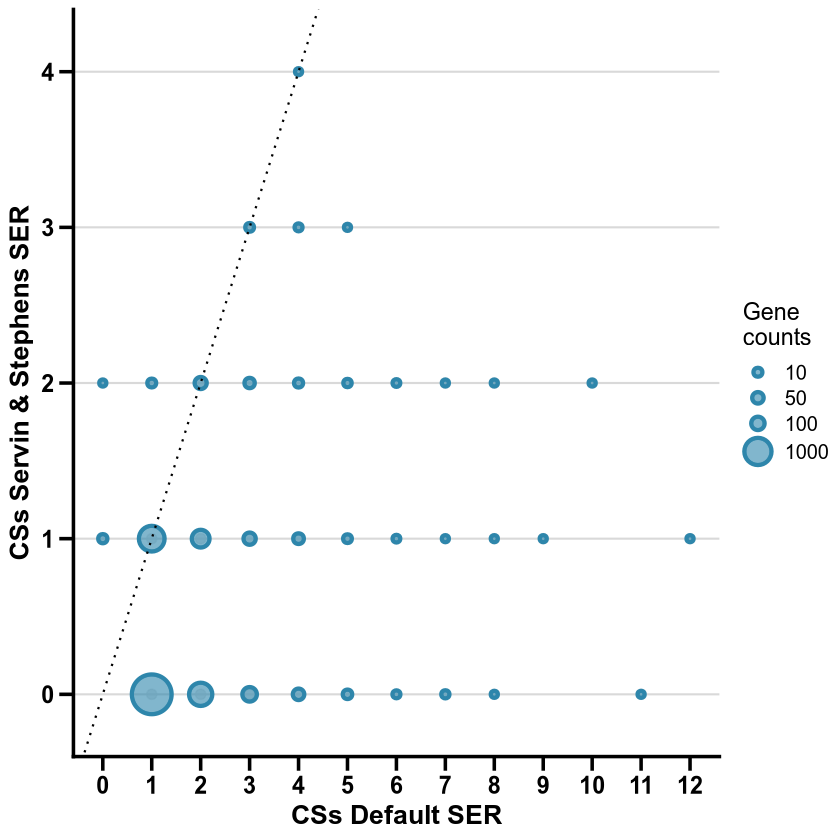

In [22]:
#Miga results -----


mat <- matrix(c(# 12232
  0, 12, 1, 0, 0,
  2634, 858, 9, 0, 0,
  647, 284, 64, 0, 0,
  140, 68, 27, 8, 0,
  50, 33, 11, 3, 1,
  15, 8, 5, 1, 0,
  3, 2, 2, 0, 0,
  4, 1, 1, 0, 0,
  1, 1, 1, 0, 0,
  0, 1, 0, 0, 0,
  0, 0, 1, 0, 0,
  1, 0, 0, 0, 0,
  0, 1, 0, 0, 0
), nrow = 13, byrow = TRUE)


library(tidyr)
library(dplyr)
df <- as.data.frame(mat)
colnames(df) <- 0:4
df$fSuSiE <- 0:12

# Pivot longer to tidy format
df_long <- df %>%
  pivot_longer(cols = -fSuSiE, names_to = "SuSiE_topPC", values_to = "count") %>%
  mutate(
    SuSiE_topPC = as.integer(SuSiE_topPC),
    fSuSiE = as.integer(fSuSiE)
  ) %>%
  filter(count > 0)

P_Miga <- ggplot(df_long, aes(x = fSuSiE, y = SuSiE_topPC, size = count)) +
  # Background grey dots - reduced size
  geom_point(color = "gray85", size = 2.4, alpha = 0.6) +
  # Highlight with fill + outline - changed color
  geom_point(color = "#2E86AB", alpha = 0.6) +
  geom_point(shape = 1, stroke = 1.8, color = "#2E86AB") +
  # Size legend - reduced range
  scale_size_continuous(
    name = "Gene \ncounts",
    breaks = c(10, 50, 100, 1000),
    labels = c(10, 50, 100, 1000),
    range = c(0.8, 10)  # Reduced from c(1, 10)
  ) +
  # Reference diagonal
  geom_abline(slope = 1, intercept = 0, linetype = "dotted") +
  scale_x_continuous(breaks = 0:20) +
  scale_y_continuous(
    breaks = 0:20,
    expand = expansion(mult = c(0.1, 0.1))   # <-- adds space at bottom and top
  ) +
  labs(y = "CSs Servin & Stephens SER", x = "CSs Default SER") +
  # Match style from previous code
  theme_cowplot(font_size = 14) +
  theme(
    legend.position = "right",
    panel.grid.major.y = element_line(color = "gray85", size = 0.6),
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    axis.text = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 16, face = "bold"),
    plot.margin = margin(t = 2, r = 2, b = 2, l = 2, unit = "mm"),
    axis.line = element_line(size = 1.0, color = "black"),
    axis.ticks = element_line(size = 1.0, color = "black"),
    axis.ticks.length = unit(0.3, "cm"),
    plot.title = element_text(size = 20, face = "bold"),
    panel.border = element_blank(),
    panel.background = element_rect(fill = "white", color = NA)
  )
P_Miga


## Fig 1 

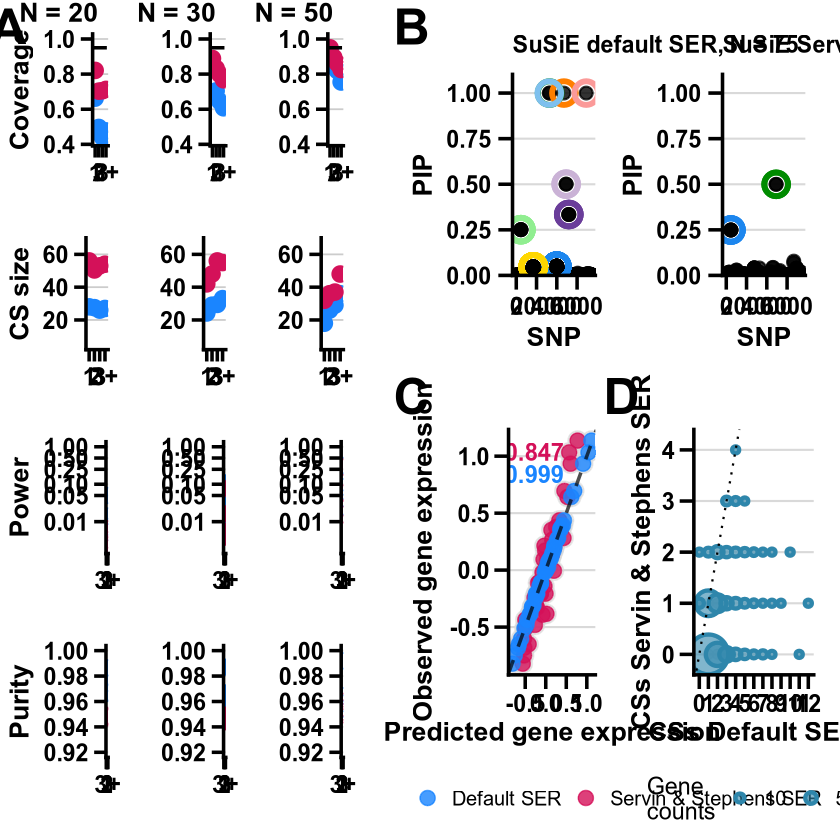

In [33]:
library(cowplot)
legend_plot <- get_legend(P_pred + theme(legend.position = "bottom"))
legend_plot_miga <- get_legend(P_Miga + theme(legend.position = "bottom"))

grid_plot <- ggdraw() +
  # Panel A (narrower, with more space after it)
  draw_plot(P_perf,
            x = 0, y = 0, width = 0.42, height = 1) +
  
  # Panel B - moved UP
  draw_plot(pip_plot_susie + theme(legend.position = "none"),
            x = 0.48, y = 0.57, width = 0.24, height = 0.4) +  # Moved up from 0.55 to 0.57
  
  # Panels C and D - moved UP
  draw_plot(P_pred,
            x = 0.48, y = 0.1, width = 0.24, height = 0.40) +  
  draw_plot(legend_plot,
            x = 0.48, y = 0.01, width = 0.24, height = 0.08) +
  
  draw_plot(pip_plot_susie_small + theme(legend.position = "none"),
            x = 0.73, y = 0.57, width = 0.24, height = 0.4) +  # Moved up from 0.55 to 0.57
  draw_plot(P_Miga + theme(legend.position = "none"),
            x = 0.74, y = 0.1, width = 0.24, height = 0.40) +  
  draw_plot(legend_plot_miga,
            x = 0.77, y = 0.01, width = 0.24, height = 0.08) +
  
  # Labels with larger font size
  draw_label("A", fontface = "bold", size = 30, x = 0.01, y = 0.99, vjust = 1) +
  draw_label("B", fontface = "bold", size = 30, x = 0.49, y = 0.99, vjust = 1) +
  draw_label("C", fontface = "bold", size = 30, x = 0.49, y = 0.55, vjust = 1) +  # Lowered to 0.55
  draw_label("D", fontface = "bold", size = 30, x = 0.74, y = 0.55, vjust = 1)   # Lowered to 0.55

plot_grid(grid_plot) + 
  theme(plot.background = element_rect(fill = "white", color = NA))

In [34]:
#ggsave(
#  "grid_plot.png", plot = grid_plot,
#  width = 16, height = 9, dpi = 300
#)

In [35]:
ggsave("figure_1_combined.pdf",
       plot = grid_plot,
       width = 450, # 500
       height = 250, # 280
       units = "mm",
       bg = "white")